In [ ]:
import requests, zipfile, io
import cv2
import glob
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import os 
from dask import bag, diagnostics
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping
import keras
import tensorflow as tf
import random
from keras.utils import to_categorical
from google.colab import drive,files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np 
from PIL import Image
import os 
from tensorflow.keras.applications.vgg16 import VGG16
# For image augmentation  to increase the quality of trained models
import albumentations as A
# Set the seed for TensorFlow
tf.random.set_seed(1)
# Set the seed for NumPy
np.random.seed(1)
# Set the seed for the Python random module
random.seed(1)

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


RUN ONLY ONCE 

In [ ]:
os.mkdir('gdrive/MyDrive/data')
os.mkdir('gdrive/MyDrive/data/Resized-cocci')
os.mkdir('gdrive/MyDrive/data/Resized-healthy')
os.mkdir('gdrive/MyDrive/data/Resized-salmo')
os.mkdir('gdrive/MyDrive/data/Resized-ncd')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/healthy.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/salmo.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/ncd.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/cocci.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
def resize(folder,save_to):
  i= 0
  images = glob.glob(folder + "/*.jpg")
  for img in  images[:500]:
    image= Image.open(img)
    image= image.resize((224,224))
    image.save(f"{save_to}/resized{i}.jpg")
    i+=1
  print(f'successfully saved to {save_to}')

In [ ]:
resize('gdrive/MyDrive/data/salmo','gdrive/MyDrive/data/Resized-salmo')
resize('gdrive/MyDrive/data/healthy','gdrive/MyDrive/data/Resized-healthy') 
resize('gdrive/MyDrive/data/cocci','gdrive/MyDrive/data/Resized-cocci') 
resize('gdrive/MyDrive/data/ncd','gdrive/MyDrive/data/Resized-ncd')

END OF SKIPED PART

In [ ]:
# We will take only 500 images of each class 
cocci = glob.glob('gdrive/MyDrive/data/Resized-cocci/*.jpg')[:500]
healthy = glob.glob('gdrive/MyDrive/data/Resized-healthy/*.jpg')[:500]
salmo = glob.glob('gdrive/MyDrive/data/Resized-salmo/*.jpg')[:500]
ncd = glob.glob('gdrive/MyDrive/data/Resized-ncd/*.jpg')[:500]

In [ ]:
# we need to fix data imbalance (class NCD )
#Using Data Augmentation we can quickly increase the amount of data for our imbalanced classes,
#this will ensure that our model does not see the same image twice and helps avoid overfitting and aids the model to generalise better.
datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
("Cocci",len(cocci)) ,("Healthy",len(healthy)),("NCD", len(ncd)),("Salmo",len(salmo))

(('Cocci', 500), ('Healthy', 500), ('NCD', 376), ('Salmo', 500))

In [ ]:
# we need to increase number of images in NCD class to be 500, which is the same as other classes 
# 376 + 124 = 500
#os.mkdir('ncd_over-sampling')
total = 0
for img in ncd:
  x = load_img(img) 
  x = img_to_array(x) # this is a Numpy array with shape (3, 150, 150)
  x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)
  for i in datagen.flow(x,save_to_dir="ncd_over-sampling",save_format="jpg"):
    break 
  if total == 124:
    break
  total = total + 1  

In [ ]:
over = glob.glob('ncd_over-sampling/*.jpg')[:500]
print(len(over))
ncd = ncd + over
print("NCD : ",len(ncd))

124
NCD :  500


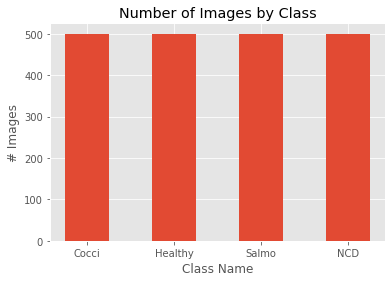

In [ ]:
dict_ = {"Cocci":len(cocci) ,
         "Healthy":len(healthy),
         "Salmo":len(salmo),
         "NCD":len(ncd)}
plt.bar(dict_.keys(), dict_.values(), width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name');
plt.ylabel('# Images');
plt.show()

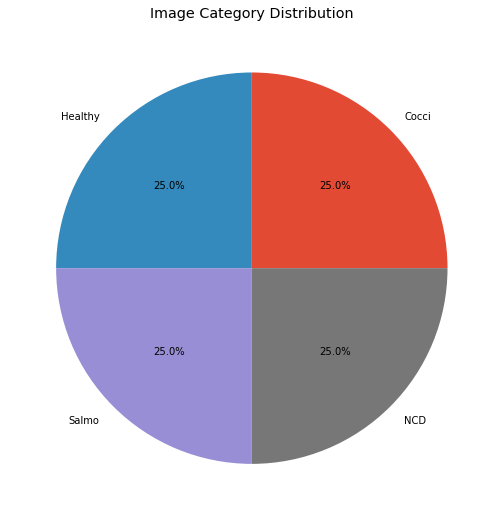

In [ ]:
labels = dict_.keys()
targets = dict_.values()
plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

In [ ]:
labels = []
data =[] 

In [ ]:
def prepare_images(array,class_no):
  for img in array:
    x = load_img(img)
    x = img_to_array(x)
    data.append(x)
    labels.append(class_no)

In [ ]:
prepare_images(cocci,0)
prepare_images(healthy,1)
prepare_images(salmo,2)
prepare_images(ncd,3)

In [ ]:
data = np.array(data)
labels = to_categorical(labels)

In [ ]:
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2, random_state=1,shuffle=True)

In [ ]:
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_tl.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3),  metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train,ytrain, epochs = 100 , batch_size=32,validation_data=(X_test, ytest),callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
50/50 [==============================] - 21s 221ms/step - loss: 0.9267 - accuracy: 0.7469 - val_loss: 0.3300 - val_accuracy: 0.8775
Epoch 2/100
50/50 [==============================] - 9s 183ms/step - loss: 0.2933 - accuracy: 0.8913 - val_loss: 0.3740 - val_accuracy: 0.8650
Epoch 3/100
50/50 [==============================] - 9s 187ms/step - loss: 0.1976 - accuracy: 0.9344 - val_loss: 0.2424 - val_accuracy: 0.9100
Epoch 4/100
50/50 [==============================] - 9s 184ms/step - loss: 0.1478 - accuracy: 0.9500 - val_loss: 0.3103 - val_accuracy: 0.8800
Epoch 5/100
50/50 [==============================] - 9s 190ms/step - loss: 0.1143 - accuracy: 0.9631 - val_loss: 0.2156 - val_accuracy: 0.9275
Epoch 6/100
50/50 [==============================] - 9s 187ms/step - loss: 0.0825 - accuracy: 0.9725 - val_loss: 0.2062 - val_accuracy: 0.9250
Epoch 7/100
50/50 [==============================] - 10s 191ms/step - loss: 0.0655 - accuracy: 0.9794 - val_loss: 0.2094 - val_accuracy: 0.93

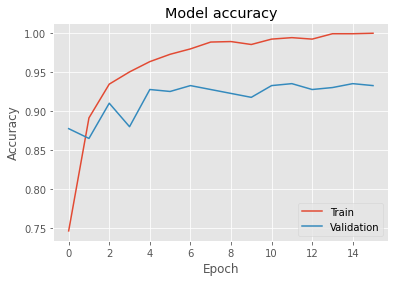

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# load the best model
best_model_tl = keras.models.load_model('best_model_tl.h5')

In [ ]:
# Get predictions
y_pred = best_model_tl.predict(X_test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_class = np.argmax(ytest, axis=1)

# Get confusion matrix
confusion_mat = confusion_matrix(y_true_class, y_pred_class)
print("\n--- Confusion Matrix ---\n")
print(confusion_mat)
# Get classification report
classification = classification_report(y_true_class, y_pred_class)
print("\n\n\t\t--- Classification Report ---\n")
print(classification)

13/13 [==============================] - 2s 151ms/step

--- Confusion Matrix ---

[[92  1  1  1]
 [ 0 96  2  2]
 [ 2  2 94  4]
 [ 4  3  4 92]]


		--- Classification Report ---

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        95
           1       0.94      0.96      0.95       100
           2       0.93      0.92      0.93       102
           3       0.93      0.89      0.91       103

    accuracy                           0.94       400
   macro avg       0.93      0.94      0.94       400
weighted avg       0.93      0.94      0.93       400



In [ ]:
# Unfreeze some layers in the base model
base_model.trainable = True
# free some memory 
del best_model_tl
del data 
del labels 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),  metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_fn.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    X_train,ytrain, epochs = 100 , batch_size=12,validation_data=(X_test, ytest),callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
134/134 [==============================] - 34s 219ms/step - loss: 1.9758 - accuracy: 0.4769 - val_loss: 1.0516 - val_accuracy: 0.5025
Epoch 2/100
134/134 [==============================] - 27s 201ms/step - loss: 0.8977 - accuracy: 0.6150 - val_loss: 0.5918 - val_accuracy: 0.7850
Epoch 3/100
134/134 [==============================] - 27s 203ms/step - loss: 0.5948 - accuracy: 0.7719 - val_loss: 0.5206 - val_accuracy: 0.8200
Epoch 4/100
134/134 [==============================] - 27s 203ms/step - loss: 0.5293 - accuracy: 0.7962 - val_loss: 0.4461 - val_accuracy: 0.8300
Epoch 5/100
134/134 [==============================] - 27s 205ms/step - loss: 0.4930 - accuracy: 0.8075 - val_loss: 0.3663 - val_accuracy: 0.8625
Epoch 6/100
134/134 [==============================] - 27s 204ms/step - loss: 0.4521 - accuracy: 0.8163 - val_loss: 0.3079 - val_accuracy: 0.8675
Epoch 7/100
134/134 [==============================] - 27s 201ms/step - loss: 0.3564 - accuracy: 0.8500 - val_loss: 0.3383 -

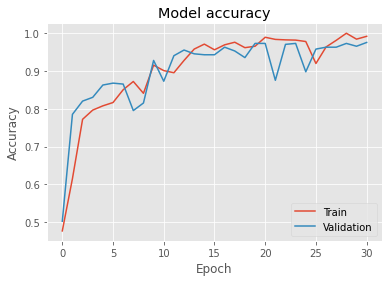

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# load the best model
best_model_fn = keras.models.load_model('best_model_fn.h5')

In [ ]:
# Get predictions
y_pred = best_model_fn.predict(X_test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_class = np.argmax(ytest, axis=1)

# Get confusion matrix
confusion_mat = confusion_matrix(y_true_class, y_pred_class)
print("\n--- Confusion Matrix ---\n")
print(confusion_mat)
# Get classification report
classification = classification_report(y_true_class, y_pred_class)
print("\n\n\t\t--- Classification Report ---\n")
print(classification)

13/13 [==============================] - 2s 157ms/step

--- Confusion Matrix ---

[[ 94   0   0   1]
 [  0  95   3   2]
 [  1   0 101   0]
 [  1   1   1 100]]


		--- Classification Report ---

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        95
           1       0.99      0.95      0.97       100
           2       0.96      0.99      0.98       102
           3       0.97      0.97      0.97       103

    accuracy                           0.97       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.97      0.97       400

